In [18]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import json

In [19]:
import random

# === –§–∏–∫—Å–∏—Ä—É–µ–º SEED –¥–ª—è –ø–æ–≤—Ç–æ—Ä—è–µ–º–æ—Å—Ç–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ ===
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# === –î–ª—è DataLoader —Å num_workers > 0 ===
def seed_worker(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(SEED)

In [20]:
DATA_PATH = 'dataset/maria.csv'
BASE_MODEL_PATH = 'password_lstm.pth'
PERSONAL_MODEL_PATH = 'personal_lstm.pth'
PATTERN_OUTPUT_PATH = 'personal_password_patterns.json'

In [21]:
# === –ü–∞—Ä–∞–º–µ—Ç—Ä—ã ===
max_sequence_length = 50
embedding_dim = 64
hidden_dim = 128
batch_size = 64
num_epochs = 10

In [22]:
# === –û–ø—Ä–µ–¥–µ–ª—è–µ–º –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É LSTM ===
class PasswordLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(PasswordLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.fc(x)
        return x

In [23]:
# === –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏—è –º–æ–¥–µ–ª–∏ ===
def save_model(model, optimizer, epoch, file_path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }
    torch.save(checkpoint, file_path)
    print(f"‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ '{file_path}'")

In [24]:
# === –§—É–Ω–∫—Ü–∏—è –¥–ª—è –∑–∞–≥—Ä—É–∑–∫–∏ –º–æ–¥–µ–ª–∏ ===
def load_model(model, optimizer, file_path):
    if os.path.exists(file_path):
        checkpoint = torch.load(file_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"‚úÖ –ú–æ–¥–µ–ª—å –∑–∞–≥—Ä—É–∂–µ–Ω–∞ –∏–∑ '{file_path}' ‚Äî –ø—Ä–æ–¥–æ–ª–∂–∞–µ–º —Å —ç–ø–æ—Ö–∏ {start_epoch + 1}")
        return start_epoch
    else:
        print("‚ö†Ô∏è –§–∞–π–ª —Å –º–æ–¥–µ–ª—å—é –Ω–µ –Ω–∞–π–¥–µ–Ω ‚Äî –Ω–∞—á–∏–Ω–∞–µ–º –æ–±—É—á–µ–Ω–∏–µ —Å –Ω—É–ª—è.")
        return 0

In [25]:
# === –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ —Ç–æ–∫–µ–Ω–∏–∑–∞—Ü–∏–∏ ===
base_chars = set('abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!@#$%^&*()-_=+[]{}|;:,.<>?/\\')
char_to_idx = {char: idx + 1 for idx, char in enumerate(base_chars)}
char_to_idx['<PAD>'] = 0
char_to_idx['<UNK>'] = len(char_to_idx) + 1
idx_to_char = {idx: char for char, idx in char_to_idx.items()}


In [26]:
# === –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö ===
def prepare_data(passwords, char_to_idx):
    sequences = [[char_to_idx.get(char, char_to_idx['<UNK>']) for char in password] for password in passwords]
    sequences = [seq[:max_sequence_length] + [0] * (max_sequence_length - len(seq)) for seq in sequences]

    X = torch.tensor(sequences, dtype=torch.long)
    y = torch.tensor([seq[1:] + [0] for seq in sequences], dtype=torch.long)

    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, worker_init_fn=seed_worker, generator=g)

In [27]:
# === –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –±–∞–∑–æ–≤–æ–π –º–æ–¥–µ–ª–∏ ===
vocab_size = len(char_to_idx)
base_model = PasswordLSTM(vocab_size, embedding_dim, hidden_dim)
base_optimizer = optim.Adam(base_model.parameters(), lr=0.001)

In [28]:
# === –ü–æ–ø—Ä–æ–±—É–µ–º –∑–∞–≥—Ä—É–∑–∏—Ç—å –±–∞–∑–æ–≤—É—é –º–æ–¥–µ–ª—å ===
start_epoch = load_model(base_model, base_optimizer, BASE_MODEL_PATH)

‚ö†Ô∏è –§–∞–π–ª —Å –º–æ–¥–µ–ª—å—é –Ω–µ –Ω–∞–π–¥–µ–Ω ‚Äî –Ω–∞—á–∏–Ω–∞–µ–º –æ–±—É—á–µ–Ω–∏–µ —Å –Ω—É–ª—è.


In [29]:
# === –ó–∞–≥—Ä—É–∂–∞–µ–º –ª–∏—á–Ω—ã–µ –ø–∞—Ä–æ–ª–∏ ===
if os.path.exists(DATA_PATH):
    personal_data = pd.read_csv(DATA_PATH)['String'].tolist()
    personal_loader = prepare_data(personal_data, char_to_idx)
else:
    raise FileNotFoundError("‚ö†Ô∏è –§–∞–π–ª 'maria.csv' –Ω–µ –Ω–∞–π–¥–µ–Ω!")

In [30]:
# === –°–æ–∑–¥–∞–Ω–∏–µ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏ –¥–ª—è –ª–∏—á–Ω—ã—Ö –ø–∞—Ä–æ–ª–µ–π ===
personal_model = PasswordLSTM(vocab_size, embedding_dim, hidden_dim)
personal_optimizer = optim.Adam(personal_model.parameters(), lr=0.001)


In [31]:
# === –°–∏–Ω—Ö—Ä–æ–Ω–∏–∑–∏—Ä—É–µ–º –≤–µ—Å–∞ –Ω–æ–≤–æ–π –º–æ–¥–µ–ª–∏ —Å –±–∞–∑–æ–≤–æ–π ===
personal_model.load_state_dict(base_model.state_dict())

<All keys matched successfully>

Epoch 1/10, Loss: 4.5629
Epoch 2/10, Loss: 4.4302
Epoch 3/10, Loss: 4.2817
Epoch 4/10, Loss: 4.0968
Epoch 5/10, Loss: 3.8576
Epoch 6/10, Loss: 3.5517
Epoch 7/10, Loss: 3.1800
Epoch 8/10, Loss: 2.7686
Epoch 9/10, Loss: 2.3670
Epoch 10/10, Loss: 2.0147


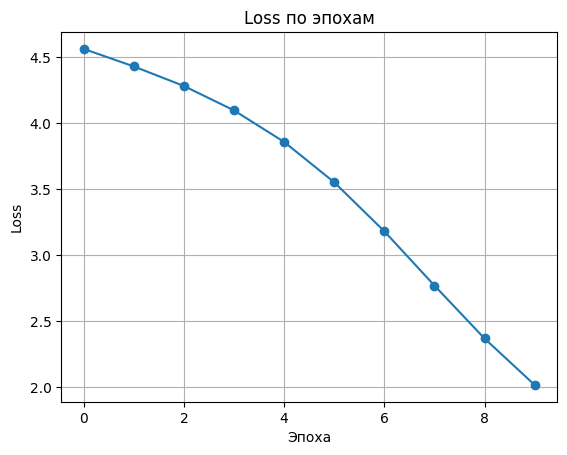

In [32]:
# === –û–±—É—á–µ–Ω–∏–µ –ª–∏—á–Ω–æ–π –º–æ–¥–µ–ª–∏ —Å –ª–æ–≥–æ–º –ø–æ—Ç–µ—Ä—å ===


def train_model(model, dataloader, optimizer, loss_fn, num_epochs):
    """
    –û–±—É—á–∞–µ—Ç –º–æ–¥–µ–ª—å –Ω–∞ –∑–∞–¥–∞–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å–ø–∏—Å–æ–∫ –ø–æ—Ç–µ—Ä—å –ø–æ —ç–ø–æ—Ö–∞–º.
    
    Args:
        model (nn.Module): –º–æ–¥–µ–ª—å PyTorch
        dataloader (DataLoader): –æ–±—É—á–∞—é—â–∞—è –≤—ã–±–æ—Ä–∫–∞
        optimizer (torch.optim.Optimizer): –æ–ø—Ç–∏–º–∏–∑–∞—Ç–æ—Ä
        loss_fn (nn.Module): —Ñ—É–Ω–∫—Ü–∏—è –ø–æ—Ç–µ—Ä—å
        num_epochs (int): –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö
    
    Returns:
        list: —Å–ø–∏—Å–æ–∫ –∑–Ω–∞—á–µ–Ω–∏–π –ø–æ—Ç–µ—Ä—å –ø–æ —ç–ø–æ—Ö–∞–º
    """
    model.train()
    loss_history = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_x, batch_y in dataloader:
            optimizer.zero_grad()
            output = model(batch_x)
            loss = loss_fn(output.view(-1, model.fc.out_features), batch_y.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

    return loss_history

loss_fn = nn.CrossEntropyLoss()
loss_history = train_model(personal_model, personal_loader, personal_optimizer, loss_fn, num_epochs)

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
import matplotlib.pyplot as plt

plt.plot(loss_history, marker='o')
plt.title('Loss –ø–æ —ç–ø–æ—Ö–∞–º')
plt.xlabel('–≠–ø–æ—Ö–∞')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [34]:
# === –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ª–∏—á–Ω–æ–π –º–æ–¥–µ–ª–∏ ===
save_model(personal_model, personal_optimizer, num_epochs - 1, PERSONAL_MODEL_PATH)


‚úÖ –ú–æ–¥–µ–ª—å —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∞ –≤ 'personal_lstm.pth'


In [35]:
# === –ê–Ω–∞–ª–∏–∑ —Å—Ç—Ä—É–∫—Ç—É—Ä—ã –ø–∞—Ä–æ–ª—è ===
import re
from typing import List, Dict

def analyze_passwords(passwords: List[str]) -> Dict:
    """
    –ê–Ω–∞–ª–∏–∑–∏—Ä—É–µ—Ç —Å–ø–∏—Å–æ–∫ –ø–∞—Ä–æ–ª–µ–π –∏ –≤–æ–∑–≤—Ä–∞—â–∞–µ—Ç —Å—Ç—Ä—É–∫—Ç—É—Ä—É –ø–æ–≤—Ç–æ—Ä—è—é—â–∏—Ö—Å—è —à–∞–±–ª–æ–Ω–æ–≤:
    - –¶–∏—Ñ—Ä—ã
    - –ß–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è –ø–æ–¥—Å—Ç—Ä–æ–∫–∏
    - –ú—É—Ç–∞—Ü–∏–∏
    - Zigzag-—Ä–µ–≥–∏—Å—Ç—Ä
    - –ú–∞—Å–∫–∏
    - –ü—Ä–æ—Ñ–∏–ª—å –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è

    Returns:
        dict: —Å–ª–æ–≤–∞—Ä—å —Å –∞–Ω–∞–ª–∏–∑–æ–º —Å—Ç—Ä—É–∫—Ç—É—Ä—ã –ø–∞—Ä–æ–ª–µ–π
    """
    numbers = {}
    words = {}
    mutations = {}
    masks = {}
    mutation_map = {'0': 'o', '1': 'i', '@': 'a', '$': 's', '3': 'e', '5': 's', '7': 't'}

    mutation_count = 0
    zigzag_count = 0
    number_count = 0
    word_count = 0

    def extract_mask(pwd):
        return ''.join([
            'X' if c.isalpha() else
            'D' if c.isdigit() else
            'S' if re.match(r'[!@#$%^&*()\-_=+]', c) else '_'
            for c in pwd
        ])

    for pwd in passwords:
        # --- –º–∞—Å–∫–∏ ---
        m = extract_mask(pwd)
        masks[m] = masks.get(m, 0) + 1

        # --- —Ü–∏—Ñ—Ä—ã ---
        digits = ''.join(filter(str.isdigit, pwd))
        if digits:
            number_count += 1
            for d in set(digits):
                numbers[d] = numbers.get(d, 0) + 1

        # --- —Å–ª–æ–≤–∞ (3‚Äì7 —Å–∏–º–≤–æ–ª–æ–≤) ---
        local_word_found = False
        for length in range(3, 8):
            for i in range(len(pwd) - length + 1):
                substr = pwd[i:i + length]
                words[substr] = words.get(substr, 0) + 1
                local_word_found = True
        if local_word_found:
            word_count += 1

        # --- –º—É—Ç–∞—Ü–∏–∏ ---
        mutated = ''.join([mutation_map.get(c, c) for c in pwd])
        if mutated != pwd:
            mutation_count += 1
            mutations[mutated] = mutations.get(mutated, 0) + 1

        # --- zigzag ---
        if any(c.isupper() for c in pwd) and any(c.islower() for c in pwd):
            zigzag_count += 1

    total = len(passwords)
    profile = {
        "mutation_usage": f"{(mutation_count / total) * 100:.2f}%",
        "zigzag_usage": f"{(zigzag_count / total) * 100:.2f}%",
        "number_usage": f"{(number_count / total) * 100:.2f}%",
        "word_usage": f"{(word_count / total) * 100:.2f}%"
    }

    return {
        "numbers": numbers,
        "words": words,
        "mutations": mutations,
        "masks": masks,
        "profile": profile
    }


In [ ]:
# === –í—ã–ø–æ–ª–Ω—è–µ–º –∞–Ω–∞–ª–∏–∑ –Ω–∞ –ª–∏—á–Ω—ã—Ö –ø–∞—Ä–æ–ª—è—Ö ===
results = analyze_passwords(personal_data)


In [ ]:
import re

# def extract_mask(password):
#     mask = ''
#     for char in password:
#         if char.islower() or char.isupper():
#             mask += 'X'
#         elif char.isdigit():
#             mask += 'D'
#         elif re.match(r'[!@#$%^&*()\-_=+]', char):
#             mask += 'S'
#         else:
#             mask += '_'
#     return mask

def classify_mask(mask: str) -> str:
    if all(c == 'D' for c in mask):
        return "—Ü–∏—Ñ—Ä–æ–≤–æ–π"
    if all(c == 'X' for c in mask):
        return "—Å–ª–æ–≤–µ—Å–Ω—ã–π"
    if all(c == 'S' for c in mask):
        return "—Å–ø–µ—Ü—Å–∏–º–≤–æ–ª—ã"
    if 'X' in mask and 'D' in mask and 'S' in mask:
        return "–≥–∏–±—Ä–∏–¥: –±—É–∫–≤—ã + —Ü–∏—Ñ—Ä—ã + —Å–∏–º–≤–æ–ª—ã"
    if 'X' in mask and 'D' in mask:
        return "–≥–∏–±—Ä–∏–¥: –±—É–∫–≤—ã + —Ü–∏—Ñ—Ä—ã"
    if 'D' in mask and 'S' in mask:
        return "–≥–∏–±—Ä–∏–¥: —Ü–∏—Ñ—Ä—ã + —Å–∏–º–≤–æ–ª—ã"
    if 'X' in mask and 'S' in mask:
        return "–≥–∏–±—Ä–∏–¥: –±—É–∫–≤—ã + —Å–∏–º–≤–æ–ª—ã"
    if mask.lower() != mask and mask.upper() != mask and 'X' in mask:
        return "–∑–∏–≥–∑–∞–≥-—Ä–µ–≥–∏—Å—Ç—Ä"
    return "–¥—Ä—É–≥–æ–µ"

# results = analyze_passwords(personal_data)
results["mask_types"] = {
    mask: classify_mask(mask) for mask in results["masks"]
}
# –°–±–æ—Ä –º–∞—Å–æ–∫
# mask_stats = {}
# for pwd in personal_data:
#     m = extract_mask(pwd)
#     mask_stats[m] = mask_stats.get(m, 0) + 1

In [46]:
# === –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ –ø—Ä–æ—Ñ–∏–ª—è –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è ===
total_passwords = len(personal_data)
print(results["profile"])


{'mutation_usage': '100.00%', 'zigzag_usage': '100.00%', 'number_usage': '100.00%', 'word_usage': '100.00%'}


In [47]:
# === –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã ===

with open(PATTERN_OUTPUT_PATH, 'w') as f:
    json.dump(results, f, indent=4)

print("‚úÖ –õ–∏—á–Ω–∞—è –º–æ–¥–µ–ª—å –æ–±—É—á–µ–Ω–∞ –∏ –ø—Ä–æ—Ñ–∏–ª—å –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω!")

‚úÖ –õ–∏—á–Ω–∞—è –º–æ–¥–µ–ª—å –æ–±—É—á–µ–Ω–∞ –∏ –ø—Ä–æ—Ñ–∏–ª—å –ø–æ–ª—å–∑–æ–≤–∞—Ç–µ–ª—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω!


C:\Users\ggene\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


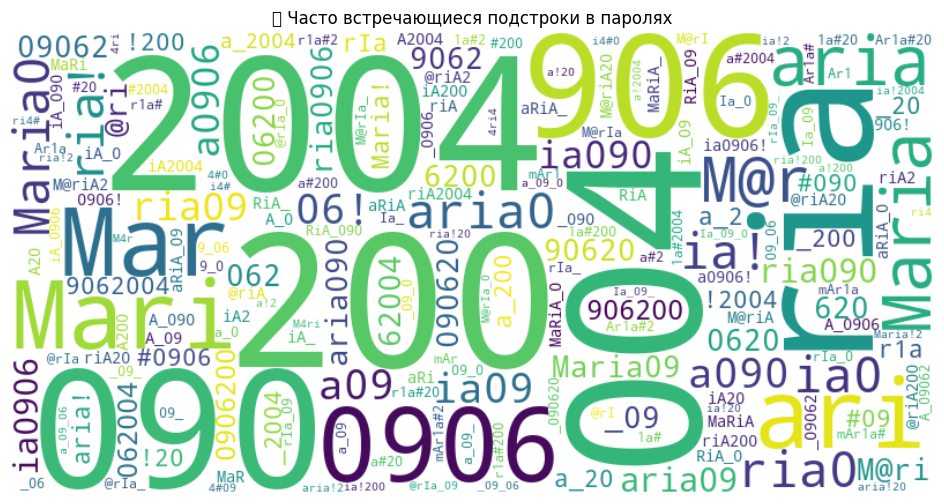

In [51]:
from wordcloud import WordCloud

word_freq = results["words"]
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("üî• –ß–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞—é—â–∏–µ—Å—è –ø–æ–¥—Å—Ç—Ä–æ–∫–∏ –≤ –ø–∞—Ä–æ–ª—è—Ö")
plt.show()

C:\Users\ggene\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129516 (\N{DNA DOUBLE HELIX}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


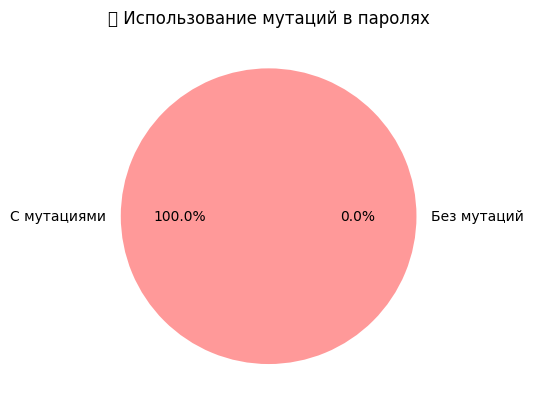

In [52]:
mutation_percent = float(results["profile"]["mutation_usage"].strip('%'))
plt.pie(
    [mutation_percent, 100 - mutation_percent],
    labels=["–° –º—É—Ç–∞—Ü–∏—è–º–∏", "–ë–µ–∑ –º—É—Ç–∞—Ü–∏–π"],
    autopct='%1.1f%%',
    colors=["#ff9999", "#66b3ff"]
)
plt.title("üß¨ –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ –º—É—Ç–∞—Ü–∏–π –≤ –ø–∞—Ä–æ–ª—è—Ö")
plt.show()
